In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import misc
from scipy.stats import norm, lognorm

We model stock price as a stochastic variable with drift $\mu$ and vol $\sigma$ such that:
\begin{equation}
    S_1 = S_0(1 + \mu dt + \sigma \sqrt{t}dw)
\end{equation}

For small time-scales, and small volatility, we can use lognormal returns as an approximation.

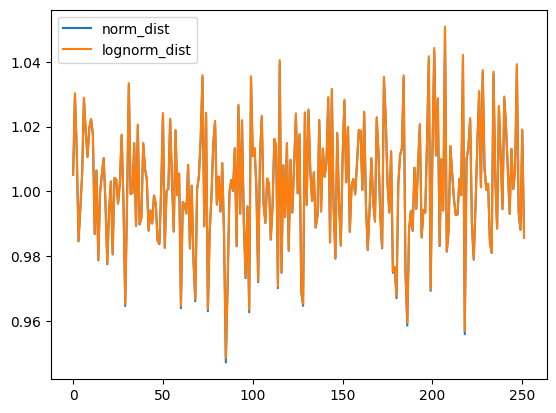

In [5]:
# Simulate daily returns for 1 year
drift = 0.02
vol = 0.3
step_size = 1/252

rn = np.random.rand(252)
norm1 = norm.ppf(rn, loc=drift * step_size, scale=vol * np.sqrt(step_size)) + 1
plt.plot(norm1, label='norm_dist')

lognorm1 = lognorm.ppf(rn, vol * np.sqrt(step_size), loc=0, scale=np.exp(drift * step_size))
plt.plot(lognorm1, label='lognorm_dist')
plt.legend()
plt.show()

Estimate the error of the lognormal approximation by simulating the returns after 1 year:

In [9]:
# normal distribution
f = 1 + drift + vol * np.random.normal(0, 1, size=10000000)
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift: {drift}')

mean return after 1 year: 0.02012067860673339
drift: 0.02


In [11]:
# lognormal distribution
f = lognorm.ppf(np.random.rand(100000000), s=vol, loc=0, scale=np.exp(drift))
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift + 0.5 * vol^2: {0.5 * vol ** 2 + drift}')

mean return after 1 year: 0.06711097463918114
drift + 0.5 * vol^2: 0.065


Difference between normal and lognormal distributions is $0.5\text{vol}^2$.

We note that the expectation of lognormal distribution with mean $\mu$ and standard deviation $\sigma$ is $e^{\mu + \frac{\sigma ^ 2}{2}}$.

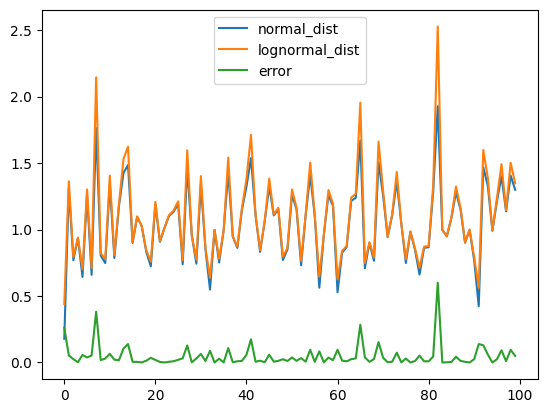

In [17]:
# simulate error for each calculation
n = []
lgn = []
for i in range(100):
    w = np.random.rand()
    n.append(1 + drift + vol * norm.ppf(w, loc=0, scale=1))
    lgn.append(lognorm.ppf(w, s=vol, loc=0, scale=np.exp(drift)))

n = np.array(n)
lgn = np.array(lgn)

plt.plot(n, label='normal_dist')
plt.plot(lgn, label='lognormal_dist')
plt.plot((lgn - n), label='error')
plt.legend()
plt.show()

Errors are random and small compared to correct returns

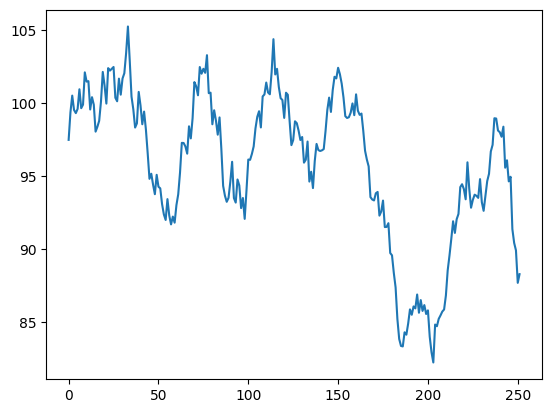

In [26]:
drift = 0.01
vol = 0.2
initial_stock_price = 100

def generate_stochastic_stock_price(drift, vol, initial_price, num_steps, step_size):
    '''
    drift, vol, step_size to be quoted as annualised values
    e.g. step_size = (1 / 252) for daily stock price
    '''
    w = np.random.normal(0, 1, size=num_steps)
    returns = 1 + drift * step_size + vol * np.sqrt(step_size) * w
    prices = initial_price * np.cumprod(returns)
    return prices

plt.plot(generate_stochastic_stock_price(drift, vol, initial_stock_price, 252, 1 / 252))


value at the end is ~ 0.007936507936507938


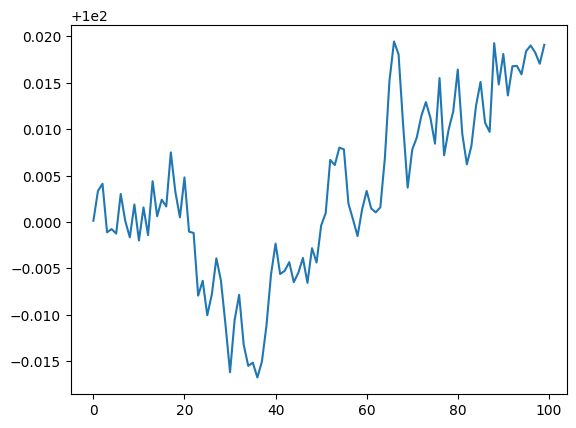

In [3]:
price_series_arr = np.array([generate_stochastic_stock_price(drift, vol, initial_stock_price, 100, 1/252) for f in range(100000)])
# for f in price_series_arr:
#     plt.plot(f)
# plt.show()
plt.plot(np.mean(price_series_arr, axis=0))
step_size = 100/252
print(f'value at the end is ~ {0.5 * (vol * np.sqrt(step_size))**2}')

In [4]:
def test():
    test = np.random.rand(252)

    drift = 0.01
    step_size = 1/252

    norm1 = norm.ppf(test, loc=drift * step_size, scale=vol * np.sqrt(step_size))

    
    # plt.plot(1 + norm1)

    lognorm1 = lognorm.ppf(test, vol * np.sqrt(step_size), loc=0, scale=np.exp(drift * step_size))
    # plt.plot(lognorm1)

    return lognorm1[-1]

vol = 0.3
drift = 0.02


0.06712381934576506
0.065


In [5]:
f1 = [np.prod(lognorm.ppf(np.random.rand(252), s=vol/np.sqrt(252), loc=0, scale=np.exp(drift/252)), axis=0) for i in range(100000)]
print(np.mean(f1) - 1)
print(0.5 * (vol) ** 2 + drift)

0.06621502011395441
0.065


In [6]:
f2 = 1 + drift + vol * np.random.normal(0, 1, size= 100000)
print(np.mean(f2) - 1)
print(0.5 * (vol) ** 2 + drift)

0.01916990404320118
0.065


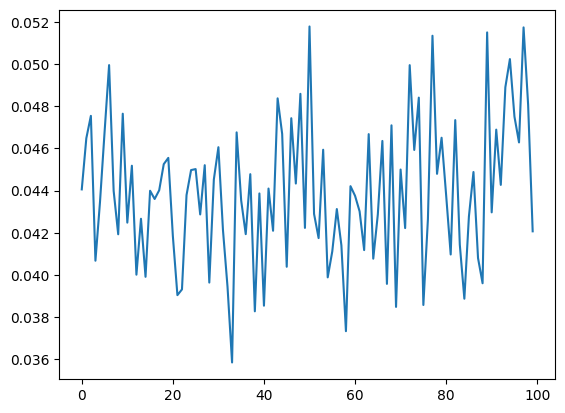